## 모듈 import

In [1]:
#모듈 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pycaret.classification  import *


# feature selection
from sklearn.tree import DecisionTreeClassifier
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

#Scailing
from sklearn.preprocessing import PowerTransformer

#Label Encoding
from sklearn.preprocessing import LabelEncoder

In [2]:
#삡운드
import winsound as sd
# 삡싸운드
def beepsound():
    fr = 2000   # range : 37 ~ 32767
    du = 1000 # 1000 ms ==1second
    sd.Beep(fr, du) # winsound.Beep(frequency, duration)

## data 불러오기

In [3]:
# 데이터가 저장된 경로 설정
data_path = '../daplatformers2021/'

# 데이터 불러오기
train = pd.read_csv(data_path + 'trainset.csv')
test = pd.read_csv(data_path + 'testset_final.csv')
submission = pd.read_csv(data_path + 'sample_submission_final.csv')

In [4]:
train = train.drop(columns=['매니저최초가입일', '매니저최초서비스일', '매니저주소'])

### 전처리

In [1]:
data = pd.concat([train,test]).reset_index(drop=True)

- 결측치 채움

In [6]:
### 결측치 제거

# 결측치 0으로 채움
data['청소교육이수여부'] = data['청소교육이수여부'].fillna(0)
data['CS교육이수여부'] = data['CS교육이수여부'].fillna(0)
data['부재중여부'] = data['부재중여부'].fillna(0)
# 결측치 최빈값으로 채움
data['매니저이동방법'] = data['매니저이동방법'].fillna(data['매니저이동방법'].mode()[0])
data['매니저사용휴대폰'] = data['매니저사용휴대폰'].fillna(data['매니저사용휴대폰'].mode()[0])
data['고객가입일'] = data['고객가입일'].fillna(data['고객가입일'].mode()[0]) #데이터 바뀌고 test에 생긴 에러
data['결재형태'] = data['결재형태'].fillna(data['결재형태'].mode()[0]) #데이터 바뀌고 test에 생긴 에러

data['접수시각'] = data['접수시각'].fillna(data['접수시각'].mode()[0])
data['반려동물'] = data['반려동물'].fillna('없음')
# 결측치 판단하여 없음으로 채움
data['우선청소'] = data['우선청소'].fillna('없음')

### 평수 평균 확인 -> 31.xx -> 30평대로 채움
# (10*len(data.query('평수 == "10평대"')) + 20*len(data.query('평수 == "20평대"')) + 
#  30*len(data.query('평수 == "30평대"')) + 40*len(data.query('평수 == "40평대이상"')))/ \
# (len(data.query('평수 == "10평대"'))+len(data.query('평수 == "20평대"'))+
#  len(data.query('평수 == "30평대"'))+len(data.query('평수 == "40평대이상"')))
data['평수'] = data['평수'].fillna('30평대')

In [7]:
#test와 train의 구조를 맞춰줌
data['매니저생년월일'] = data['매니저생년월일'].astype('str').apply(lambda x: x[0:4])
# 새로운 피처 만들기
data['매니저나이'] = data['매니저생년월일'].apply(lambda x: 2021-int(x))

In [8]:
# 저장해놓기
data_SEQ = data.SEQ
# 인코딩을 위하여 제거 / 이후 나중에 병합함
y_data = data['매칭성공여부']
data = data.drop(columns = ['SEQ','매칭성공여부'])

- Encoding, Scailing

In [9]:
#라벨인코딩

#범주형변수 수동으로 분리
data[['장기서비스여부','기존고객여부','부재중여부','쿠폰사용여부','매니저성별',
         'CS교육이수여부','청소교육이수여부','부재중서비스가능여부','추천인여부']
     ] = data[['장기서비스여부','기존고객여부','부재중여부','쿠폰사용여부','매니저성별',
         'CS교육이수여부','청소교육이수여부','부재중서비스가능여부','추천인여부'
     ]].astype('str')

# 범주형 변수와 수치형 변수를 분리
cat_features = data.select_dtypes(include=['object']).columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list() 

#수치형변수 scailing
data[num_features] = PowerTransformer(standardize=True).fit_transform(data[num_features])

#라벨인코딩
#위의 범주형 변수들을 라벨인코딩
for f in cat_features:
    data[f] = LabelEncoder().fit_transform(data[f])

#위에서 떼어놨던 피처 병합
data = pd.concat([data_SEQ, data],axis=1)
data = pd.concat([data, y_data],axis=1)

- Data split

In [12]:
#train과 test를 분리
train = data.iloc[:23009,:]
test = data.iloc[23009:,:]
test = test.drop(columns = ['매칭성공여부']).reset_index(drop=True)

### Feature selection-SelectPercentile

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:25<00:00,  3.73it/s]

(80, 0.8732507488470498)


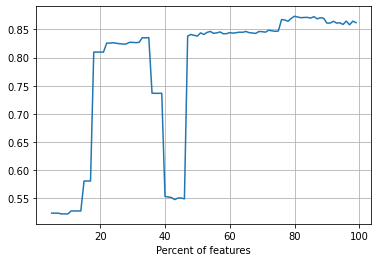

In [13]:
train_seq = train['SEQ']
test_seq = test['SEQ']
y_train = train['매칭성공여부']
train = train.drop(columns=['SEQ','매칭성공여부'])
test = test.drop(columns=['SEQ'])

# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = DecisionTreeClassifier()

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))
    
    # Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [2]:
# 위에서 구한 값으로 피처를 바꿔줌
fs = SelectPercentile(percentile=best_score[0]).fit(train, y_train)
train = fs.transform(train)
test = fs.transform(test)

# print(train.shape)
# print(data.drop(columns=['매칭성공여부']).iloc[:,1:].columns[fs.get_support()].tolist())

## Modeling with pycaret

- Model setting

In [15]:
#pycaret에 넣도록 변형
train = pd.concat([pd.DataFrame(train),y_train],axis=1)
test = pd.concat([test_seq, pd.DataFrame(test)],axis=1)

In [17]:
reg = setup(train, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '매칭성공여부', # 목표 변수는 매칭성공여부이다.
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = True, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
#             numeric_features=['전체회차','현재회차'], # 숫자로써의 의미가 있다.
            session_id = 42,
            fold_shuffle = True
            )

,Description,Value
0,session_id,42
1,Target,매칭성공여부
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(23009, 24)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,7
8,Transformed Train Set,"(22985, 23)"
9,Transformed Test Set,"(24, 23)"


In [18]:
top5 = compare_models(sort='AUC', fold=5, n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9613,0.9656,0.6524,0.9195,0.7630,0.7425,0.7557,0.6680
catboost,CatBoost Classifier,0.9431,0.9560,0.4400,0.9267,0.5960,0.5696,0.6160,7.2180
et,Extra Trees Classifier,0.9619,0.9524,0.7061,0.8714,0.7800,0.7594,0.7645,0.7920
dt,Decision Tree Classifier,0.9476,0.8669,0.7575,0.7127,0.7343,0.7052,0.7057,0.1240
gbc,Gradient Boosting Classifier,0.9073,0.8102,0.0355,0.8452,0.0676,0.0608,0.1570,2.0420
qda,Quadratic Discriminant Analysis,0.9003,0.6935,0.0732,0.4054,0.1203,0.0939,0.1351,0.0800
knn,K Neighbors Classifier,0.9012,0.5557,0.0150,0.2347,0.0282,0.0170,0.0371,0.9420
lda,Linear Discriminant Analysis,0.9044,0.5183,0.0000,0.0000,0.0000,0.0000,0.0000,0.1020
lr,Logistic Regression,0.9044,0.5168,0.0000,0.0000,0.0000,0.0000,0.0000,1.0960
nb,Naive Bayes,0.9044,0.5165,0.0000,0.0000,0.0000,0.0000,0.0000,0.0660


- Hyperparameter tuning

In [19]:
#Extra Trees Classifier 모델 생성 -> 튜닝하면 성능 하락
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9687,0.9735,0.8045,0.8592,0.8310,0.8137,0.8143
1,0.9669,0.9567,0.7318,0.9045,0.8090,0.7912,0.7965
2,0.9595,0.9495,0.7273,0.8290,0.7748,0.7527,0.7546
3,0.9648,0.9502,0.7091,0.9017,0.7939,0.7749,0.7816
4,0.9682,0.9590,0.7591,0.8930,0.8206,0.8033,0.8065
5,0.9674,0.9607,0.7352,0.9045,0.8111,0.7934,0.7985
6,0.9643,0.9585,0.7123,0.8914,0.7919,0.7726,0.7784
7,0.9721,0.9510,0.8045,0.8939,0.8469,0.8316,0.8330
8,0.9569,0.9432,0.6500,0.8667,0.7429,0.7199,0.7287
9,0.9678,0.9549,0.7545,0.8925,0.8177,0.8002,0.8036


In [10]:
# #rf -> 튜닝하면 성능 떨어짐
# rf = create_model('rf')

In [11]:
# #catboost -> 튜닝하면 성능향상
# catboost = create_model('catboost')
# #hyperparameter tuning
# catboost = tune_model(catboost, optimize = 'AUC', choose_better = True, fold = 5, n_iter = 30)
# #ensemble_model
# # cat_boost = ensemble_model(catboost, method = 'Boosting', optimize = 'AUC')

### Ensemble

- blend model

In [25]:
# # 사용할 모델 수동으로 넣어줌
# models = [
#     catboost,
#     et,
#     rf
# ]

In [12]:
# final_model = blend_models(estimator_list = models, method = 'soft', optimize = 'F1')
# final_model = finalize_model(final_model) # 전체 데이터로 재학습

- Fit & predict

In [20]:
model = et
pred_holdout = predict_model(model, test)

In [21]:
#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
pred = pd.Series([pred_holdout['Score'][i] if pred_holdout['Label'][i] =='1.0' else (1-pred_holdout['Score'][i]) for i in range(len(pred_holdout['Score']))]
)

In [22]:
submission['pred'] = pred

### Make submission 

In [23]:
t = pd.Timestamp.now()
fname = f'submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv'
# fname = 'submission_etpercentile.csv'
submission.to_csv('../submission/'+fname, index=False)
print("'{}' is ready to submit." .format(fname))

'submission_11190046.csv' is ready to submit.


In [24]:
beepsound(),beepsound(),beepsound()

(None, None, None)

# END